# Autoencoder as a Classifier using Fashion-MNIST Dataset

## Tous kodikes en tous etrexa giati itan na pari para polli ora.Apoti ekatalava en oti zita stin ergasia pano kato.To dataset en polla paromoio ara en nomizo na xriasti na allaksoume je polla 

Import necessary libraries

In [2]:
from google.colab import drive
drive.mount('/content/drive')
import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from keras.models import Model
from keras.optimizers import RMSprop
from keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K
from keras.utils import to_categorical

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Function to read the data

In [3]:
def extract_data(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(28 * 28 * num_images)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(num_images, 28,28)
        return data


In [5]:
train_data = extract_data('/content/train-images-idx3-ubyte.gz',60000)
test_data = extract_data('/content/t10k-images-idx3-ubyte.gz', 10000)

Function to read labels

In [6]:
def extract_labels(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * num_images)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
        return labels

In [8]:
train_labels = extract_labels('/content/train-labels-idx1-ubyte.gz',60000)
test_labels = extract_labels('/content/t10k-labels-idx1-ubyte.gz',10000)

Data Exploration

Let's now analyze how images in the dataset look like and also see the dimension of the images with the help of the NumPy array attribute .shape:

In [9]:
# Shapes of training set
print("Training set (images) shape: {shape}".format(shape=train_data.shape))

# Shapes of test set
print("Test set (images) shape: {shape}".format(shape=test_data.shape))

Training set (images) shape: (60000, 28, 28)
Test set (images) shape: (10000, 28, 28)


From the above output, you can see that the training data has a shape of 60000 x 28 x 28 since there are 60,000 training samples each of 28 x 28 dimensional matrix. Similarly, the test data has a shape of 10000 x 28 x 28 since there are 10,000 testing samples.

Note that in the task of reconstructing using convolutional autoencoder you won't need training and testing labels. Your training images will both act as the input as well as the ground truth similar to the labels you have in classification task.

But for the classification task you will also need your labels along with the images which you will be doing later on in the tutorial. Even though the task at hand will only be dealing with the training and testing images. However, for exploration purposes, which might give you a better intuition about the data, you'll make use of the labels.

Let's create a dictionary that will have class names with their corresponding categorical class labels:

In [10]:
# Create dictionary of target classes
label_dict = {
 0: '0',
 1: '1',
 2: '2',
 3: '3',
 4: '4',
 5: '5',
 6: '6',
 7: '7',
 8: '8',
 9: '9',
}

Now, let's take a look at a couple of the images in your dataset:

Text(0.5, 1.0, '(Label: 0)')

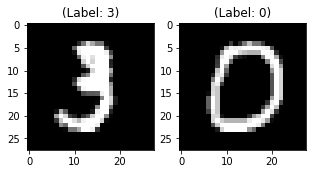

In [11]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(train_data[10], (28,28))
curr_lbl = train_labels[10]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(test_data[10], (28,28))
curr_lbl = test_labels[10]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")


Data Preprocessing

The images of the dataset are indeed grayscale images with pixel values ranging from 0 to 255 with a dimension of 28 x 28, so before we feed the data into the model, it is very important to preprocess it. You'll first convert each 28 x 28 image of train and test set into a matrix of size 28 x 28 x 1, which you can feed into the network:

In [12]:
train_data = train_data.reshape(-1, 28,28, 1)
test_data = test_data.reshape(-1, 28,28, 1)
train_data.shape, test_data.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

Next, rescale the training and testing data with the maximum pixel value of the training and testing data:

In [13]:
train_data = train_data / np.max(train_data)
test_data = test_data / np.max(test_data)

After all of this, it's important to partition the data. In order for our model to generalize well, you split the training data into two parts: a training and a validation set. You will train your model on 80% of the data and validate it on 20% of the remaining training data.

This will also help you in reducing the chances of overfitting, as you will be validating your model on data it would not have seen in the training phase.

You can use the train_test_split module of scikit-learn to divide the data properly:



In [14]:
from sklearn.model_selection import train_test_split
train_X,valid_X,train_ground,valid_ground = train_test_split(train_data,
                                                             train_data,
                                                             test_size=0.2,
                                                             random_state=13)

Note: You will be using the above data splitting twice, once for the task of reconstructing using convolutional autoencoder for which you don't need training and testing labels. That's why you will pass the training images twice. Your training images will both act as the input as well as the ground truth similar to the labels you have in the classification task.

But for the classification task, you will also pass your labels along with the images which you will be doing later on in the tutorial.

Now you are all set to define the network and feed the data into the network. So without any further ado, let's jump to the next step!

## The Convolutional Autoencoder

The images are of size 28 x 28 x 1 or a 30976-dimensional vector. You convert the image matrix to an array, rescale it between 0 and 1, reshape it so that it's of size 28 x 28 x 1, and feed this as an input to the network.

Also, you will use a batch size of 128 using a higher batch size of 256 or 512 is also preferable it all depends on the system you train your model. It contributes heavily in determining the learning parameters and affects the prediction accuracy.

In [15]:
batch_size = 64
epochs = 100
inChannel = 1
x, y = 28, 28
input_img = Input(shape = (x, y, inChannel))
num_classes = 10

As you might already know well before, the autoencoder is divided into two parts: there's an encoder and a decoder.

Encoder: It has 4 Convolution blocks, each block has a convolution layer followed by a batch normalization layer. Max-pooling layer is used after the first and second convolution blocks.

    The first convolution block will have 32 filters of size 3 x 3, followed by a downsampling (max-pooling) layer,
    The second block will have 64 filters of size 3 x 3, followed by another downsampling layer,
    The third block of encoder will have 128 filters of size 3 x 3,
    The fourth block of encoder will have 256 filters of size 3 x 3.

Decoder: It has 3 Convolution blocks, each block has a convolution layer followed by a batch normalization layer. Upsampling layer is used after the second and third convolution blocks.

    The first block will have 128 filters of size 3 x 3,
    The second block will have 64 filters of size 3 x 3 followed by another upsampling layer,
    The third block will have 32 filters of size 3 x 3 followed by another upsampling layer,
    The final layer of encoder will have 1 filter of size 3 x 3 which will reconstruct back the input having a single channel.

The max-pooling layer will downsample the input by two times each time you use it, while the upsampling layer will upsample the input by two times each time it is used.

Note: The number of filters, the filter size, the number of layers, number of epochs you train your model, are all hyperparameters and should be decided based on your own intuition, you are free to try new experiments by tweaking with these hyperparameters and measure the performance of your model. And that is how you will slowly learn the art of deep learning!

Let's create separate encoder and decoder functions since you will be using encoder weights later on for classification purpose!

In [16]:
def encoder(input_img):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 256 (small and thick)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4

def decoder(conv4):    
    #decoder
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4) #7 x 7 x 128
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5) #7 x 7 x 64
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    up1 = UpSampling2D((2,2))(conv6) #14 x 14 x 64
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 32
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    up2 = UpSampling2D((2,2))(conv7) # 28 x 28 x 32
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded

After the model is created, you have to compile it using the optimizer to be RMSProp.

Note that you also have to specify the loss type via the argument loss. In this case, that's the mean squared error, since the loss after every batch will be computed between the batch of predicted output and the ground truth using mean squared error pixel by pixel:

In [17]:
autoencoder = Model(input_img, decoder(encoder(input_img)))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

Let's visualize the layers that you created in the above step by using the summary function. This will show a number of parameters (weights and biases) in each layer and also the total parameters in your model.

In [18]:
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)       

It's finally time to train the model with Keras' fit() function! The model trains for 200 epochs. The fit() function will return a history object; By storing the result of this function in autoencoder_train, you can use it later to plot the loss function plot between training and validation which will help you to analyze your model's performance visually.

In [19]:
autoencoder_train = autoencoder.fit(train_X, train_ground, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_ground))

Epoch 1/100
750/750 [==============================] - 12s 16ms/step - loss: 0.0190 - val_loss: 0.0101
Epoch 2/100
750/750 [==============================] - 12s 16ms/step - loss: 0.0049 - val_loss: 0.0034
Epoch 3/100
750/750 [==============================] - 12s 16ms/step - loss: 0.0035 - val_loss: 0.0030
Epoch 4/100
750/750 [==============================] - 12s 16ms/step - loss: 0.0028 - val_loss: 0.0049
Epoch 5/100
750/750 [==============================] - 12s 16ms/step - loss: 0.0024 - val_loss: 0.0026
Epoch 6/100
750/750 [==============================] - 12s 16ms/step - loss: 0.0022 - val_loss: 0.0032
Epoch 7/100
750/750 [==============================] - 13s 17ms/step - loss: 0.0020 - val_loss: 0.0033
Epoch 8/100
750/750 [==============================] - 13s 17ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 9/100
750/750 [==============================] - 13s 17ms/step - loss: 0.0017 - val_loss: 0.0022
Epoch 10/100
750/750 [==============================] - 13s 17ms/step - l

Now, let's plot the loss plot between training and validation data to visualize the model performance.

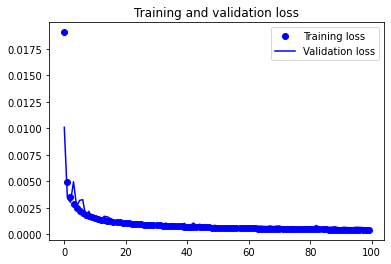

In [20]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(100)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Save the Model

Since you will need the encoder weights in your classification task, first let's save the complete autoencoder weights. You will learn how you can extract the encoder weights soon.

In [21]:
autoencoder.save_weights('autoencoder.h5')

Segmenting the fashion mnist images

Now you will be using the trained autoencoder's head, i.e., the encoder part and will be loading the weights of the autoencoder you just now trained but only in the encoder part of the model.

You will add a few dense or fully connected layers to the encoder to classify fashion mnist images.

    Let's first convert the labels into one-hot encoding vectors.

    For those of you who do not know about one-hot encoding:

    In one-hot encoding, you convert the categorical data into a vector of numbers. The reason why you convert the categorical data in one hot encoding is that machine learning algorithms cannot work with categorical data directly. You generate one boolean column for each category or class. Only one of these columns could take on the value 1 for each sample. Hence, the term one-hot encoding.

    For your problem statement, the one hot encoding will be a row vector, and for each image, it will have a dimension of 1 x 10. The important thing to note here is that the vector consists of all zeros except for the class that it represents, and for that, it is 1.

    So let's convert the labels into one-hot encoding vectors:

In [22]:
# Change the labels from categorical to one-hot encoding
train_Y_one_hot = to_categorical(train_labels)
test_Y_one_hot = to_categorical(test_labels)

# Display the change for category label using one-hot encoding
print('Original label:', train_labels[0])
print('After conversion to one-hot:', train_Y_one_hot[0])


Original label: 5
After conversion to one-hot: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


This last step is a crucial one which you all have done before as well which is splitting the data into training and validation in the autoencoder training phase. So let's quickly do that step for classification as well. Note that you will use the same random state that you used before and also this time you will pass your labels as well that you just now converted into a one-hot encoding vector.

In [23]:
train_X,valid_X,train_label,valid_label = train_test_split(train_data,train_Y_one_hot,test_size=0.2,random_state=13)

Now, let's define the classification model. Remember that you will be using the exact same encoder part as you used in the autoencoder architecture.

Let's define the fully connected layers that you will be stacking up with the encoder function.

In [24]:
def fc(enco):
    flat = Flatten()(enco)
    den = Dense(128, activation='relu')(flat)
    out = Dense(num_classes, activation='softmax')(den)
    return out

In [25]:
encode = encoder(input_img)
full_model = Model(input_img,fc(encode))

for l1,l2 in zip(full_model.layers[:19],autoencoder.layers[0:19]):
    l1.set_weights(l2.get_weights())

Note: The next step is pretty important. In order to be sure whether the weights of the encoder part of the autoencoder are similar to the weights you loaded to the encoder function of the classification model, you should always print any one of the same layers weights of both the models. If they are not similar, then there is no use in using the autoencoder classification strategy.

Let's print first layer weights of both the models.

In [26]:
autoencoder.get_weights()[0][1]

array([[[-0.0395156 , -0.60527337,  0.09634656,  0.09031664,
         -0.56085974, -0.27825293, -0.12185455, -0.31956625,
         -0.07193491,  0.519024  , -0.124329  , -0.25968188,
         -0.13662747,  0.05936673, -0.04688172, -0.07138458,
          0.0697972 ,  0.24724536, -0.37297052,  0.5721935 ,
         -0.17386411, -0.4606652 , -0.5590772 , -0.23909502,
          0.07004853,  0.49430853,  0.01477746,  0.36425093,
         -0.02937875, -0.31584734,  0.24845108,  0.49117517]],

       [[-0.30944997, -0.89968795, -0.63379633,  2.2359195 ,
         -0.88373077,  0.5157565 ,  0.04707294,  0.5403549 ,
         -0.58068687, -0.15740147, -0.4808217 , -0.6608358 ,
          0.71589094,  0.6295837 , -0.0384904 ,  0.18195452,
          0.3003406 , -0.14328052, -0.09747163,  0.14307521,
          0.08278932,  0.22544856,  0.26791632,  0.15092048,
          0.14081049, -0.43558344, -0.3569052 , -0.08669135,
          0.4392286 ,  0.29126647, -0.20228331,  0.19087426]],

       [[ 0.544462

In [27]:
full_model.get_weights()[0][1]

array([[[-0.0395156 , -0.60527337,  0.09634656,  0.09031664,
         -0.56085974, -0.27825293, -0.12185455, -0.31956625,
         -0.07193491,  0.519024  , -0.124329  , -0.25968188,
         -0.13662747,  0.05936673, -0.04688172, -0.07138458,
          0.0697972 ,  0.24724536, -0.37297052,  0.5721935 ,
         -0.17386411, -0.4606652 , -0.5590772 , -0.23909502,
          0.07004853,  0.49430853,  0.01477746,  0.36425093,
         -0.02937875, -0.31584734,  0.24845108,  0.49117517]],

       [[-0.30944997, -0.89968795, -0.63379633,  2.2359195 ,
         -0.88373077,  0.5157565 ,  0.04707294,  0.5403549 ,
         -0.58068687, -0.15740147, -0.4808217 , -0.6608358 ,
          0.71589094,  0.6295837 , -0.0384904 ,  0.18195452,
          0.3003406 , -0.14328052, -0.09747163,  0.14307521,
          0.08278932,  0.22544856,  0.26791632,  0.15092048,
          0.14081049, -0.43558344, -0.3569052 , -0.08669135,
          0.4392286 ,  0.29126647, -0.20228331,  0.19087426]],

       [[ 0.544462

Voila! Both the arrays look exactly similar. So, without any further ado, let's compile the model and start the training.

Next, you will make the encoder part i.e.the first nineteen layers of the model trainable false. Since the encoder part is already trained, you do not need to train it. You will only be training the Fully Connected part.

In [28]:
for layer in full_model.layers[0:19]:
    layer.trainable = False


Let's compile the model!

In [29]:
full_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

Let's print the summary of the model as well. There should be non-trainable parameters as well since you made the first fifteen layers of the model non-trainable.

In [30]:
full_model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_14 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_15 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 14, 14, 64)       

Train the Model

It's finally time to train the model with Keras' fit() function! The model trains for 10 epochs. The fit() function will return a history object; By storing the result of this function in fashion_train, you can use it later to plot the accuracy and loss function plots between training and validation which will help you to analyze your model's performance visually.



In [31]:
classify_train = full_model.fit(train_X, train_label, batch_size=64,epochs=100,verbose=1,validation_data=(valid_X, valid_label))

Epoch 1/100
750/750 [==============================] - 4s 6ms/step - loss: 0.2236 - accuracy: 0.9389 - val_loss: 0.1781 - val_accuracy: 0.9607
Epoch 2/100
750/750 [==============================] - 4s 5ms/step - loss: 0.0691 - accuracy: 0.9802 - val_loss: 0.1451 - val_accuracy: 0.9628
Epoch 3/100
750/750 [==============================] - 4s 5ms/step - loss: 0.0414 - accuracy: 0.9865 - val_loss: 0.1323 - val_accuracy: 0.9693
Epoch 4/100
750/750 [==============================] - 4s 5ms/step - loss: 0.0331 - accuracy: 0.9891 - val_loss: 0.1641 - val_accuracy: 0.9667
Epoch 5/100
750/750 [==============================] - 4s 5ms/step - loss: 0.0371 - accuracy: 0.9892 - val_loss: 0.2070 - val_accuracy: 0.9673
Epoch 6/100
750/750 [==============================] - 4s 5ms/step - loss: 0.0360 - accuracy: 0.9909 - val_loss: 0.1817 - val_accuracy: 0.9700
Epoch 7/100
750/750 [==============================] - 4s 5ms/step - loss: 0.0230 - accuracy: 0.9931 - val_loss: 0.1643 - val_accuracy: 0.9744

Let's save the classification model

In [32]:
full_model.save_weights('autoencoder_classification.h5')

 Next, you will re-train the model by making the first nineteen layers trainable as True instead of keeping them False! So, let's quickly do that.

In [33]:
for layer in full_model.layers[0:19]:
    layer.trainable = True

    full_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

Now let's train the entire model for one last time!

In [34]:
classify_train = full_model.fit(train_X, train_label, batch_size=64,epochs=100,verbose=1,validation_data=(valid_X, valid_label))

Epoch 1/100
750/750 [==============================] - 9s 12ms/step - loss: 0.1547 - accuracy: 0.9924 - val_loss: 1.3024 - val_accuracy: 0.9737
Epoch 2/100
750/750 [==============================] - 9s 11ms/step - loss: 0.0964 - accuracy: 0.9942 - val_loss: 0.7998 - val_accuracy: 0.9772
Epoch 3/100
750/750 [==============================] - 9s 12ms/step - loss: 0.0931 - accuracy: 0.9945 - val_loss: 0.8482 - val_accuracy: 0.9741
Epoch 4/100
750/750 [==============================] - 9s 12ms/step - loss: 0.0691 - accuracy: 0.9951 - val_loss: 0.7340 - val_accuracy: 0.9768
Epoch 5/100
750/750 [==============================] - 9s 12ms/step - loss: 0.0647 - accuracy: 0.9952 - val_loss: 0.6142 - val_accuracy: 0.9814
Epoch 6/100
750/750 [==============================] - 9s 12ms/step - loss: 0.0526 - accuracy: 0.9955 - val_loss: 0.6005 - val_accuracy: 0.9784
Epoch 7/100
750/750 [==============================] - 9s 11ms/step - loss: 0.0580 - accuracy: 0.9951 - val_loss: 0.5953 - val_accuracy:

Let's save the model for one last time.

In [35]:
full_model.save_weights('classification_complete.h5')

Let's put your model evaluation into perspective and plot the accuracy and loss plots between training and validation data:

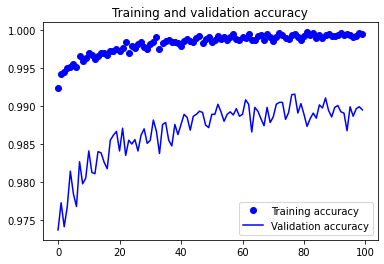

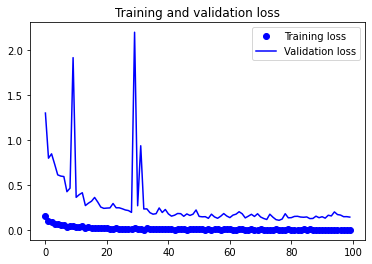

In [36]:
accuracy = classify_train.history['accuracy']
val_accuracy = classify_train.history['val_accuracy']
loss = classify_train.history['loss']
val_loss = classify_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Model Evaluation on the Test Set

Finally, let's also evaluate your model on test data and see how it performs!



In [37]:
test_eval = full_model.evaluate(test_data, test_Y_one_hot, verbose=0)

print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.10030323266983032
Test accuracy: 0.9909999966621399


Predict Labels

In [38]:
predicted_classes = full_model.predict(test_data)

Since the predictions you get are floating point values, it will not be feasible to compare the predicted labels with true test labels. So, you will round off the output which will convert the float values into an integer. Further, you will use np.argmax() to select the index number which has a higher value in a row.

For example, let's assume a prediction for one test image to be [0 1 0 0 0 0 0 0 0 0], the output for this should be a class label 1.



In [39]:
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
predicted_classes.shape, test_labels.shape

((10000,), (10000,))

Found 9909 correct labels


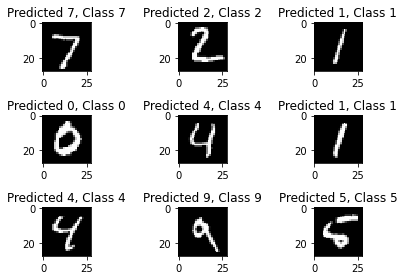

In [40]:
correct = np.where(predicted_classes==test_labels)[0]
print ("Found %d correct labels" % len(correct))
for i, correct in enumerate(correct[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_data[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], test_labels[correct]))
    plt.tight_layout()

Found 91 incorrect labels


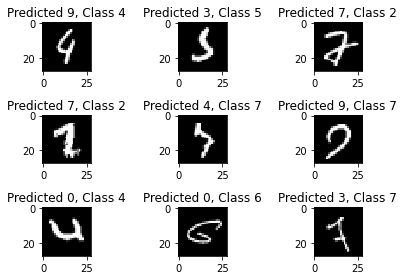

In [41]:
incorrect = np.where(predicted_classes!=test_labels)[0]
print ("Found %d incorrect labels" % len(incorrect))
for i, incorrect in enumerate(incorrect[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_data[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], test_labels[incorrect]))
    plt.tight_layout()

Classification Report

Classification report will help you in identifying the misclassified classes in more detail. You will be able to observe for which class the model performed bad out of the given ten classes.



In [42]:
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(test_labels, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.99      1.00      0.99       980
     Class 1       1.00      1.00      1.00      1135
     Class 2       0.99      0.99      0.99      1032
     Class 3       0.99      0.99      0.99      1010
     Class 4       0.99      0.99      0.99       982
     Class 5       1.00      0.99      0.99       892
     Class 6       0.99      0.99      0.99       958
     Class 7       0.99      0.99      0.99      1028
     Class 8       0.99      0.99      0.99       974
     Class 9       0.98      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

